# **Import the libraries**

In [1]:
import os
import cv2
import math
import random
import datetime as dt
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [2]:
seed_constant= 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

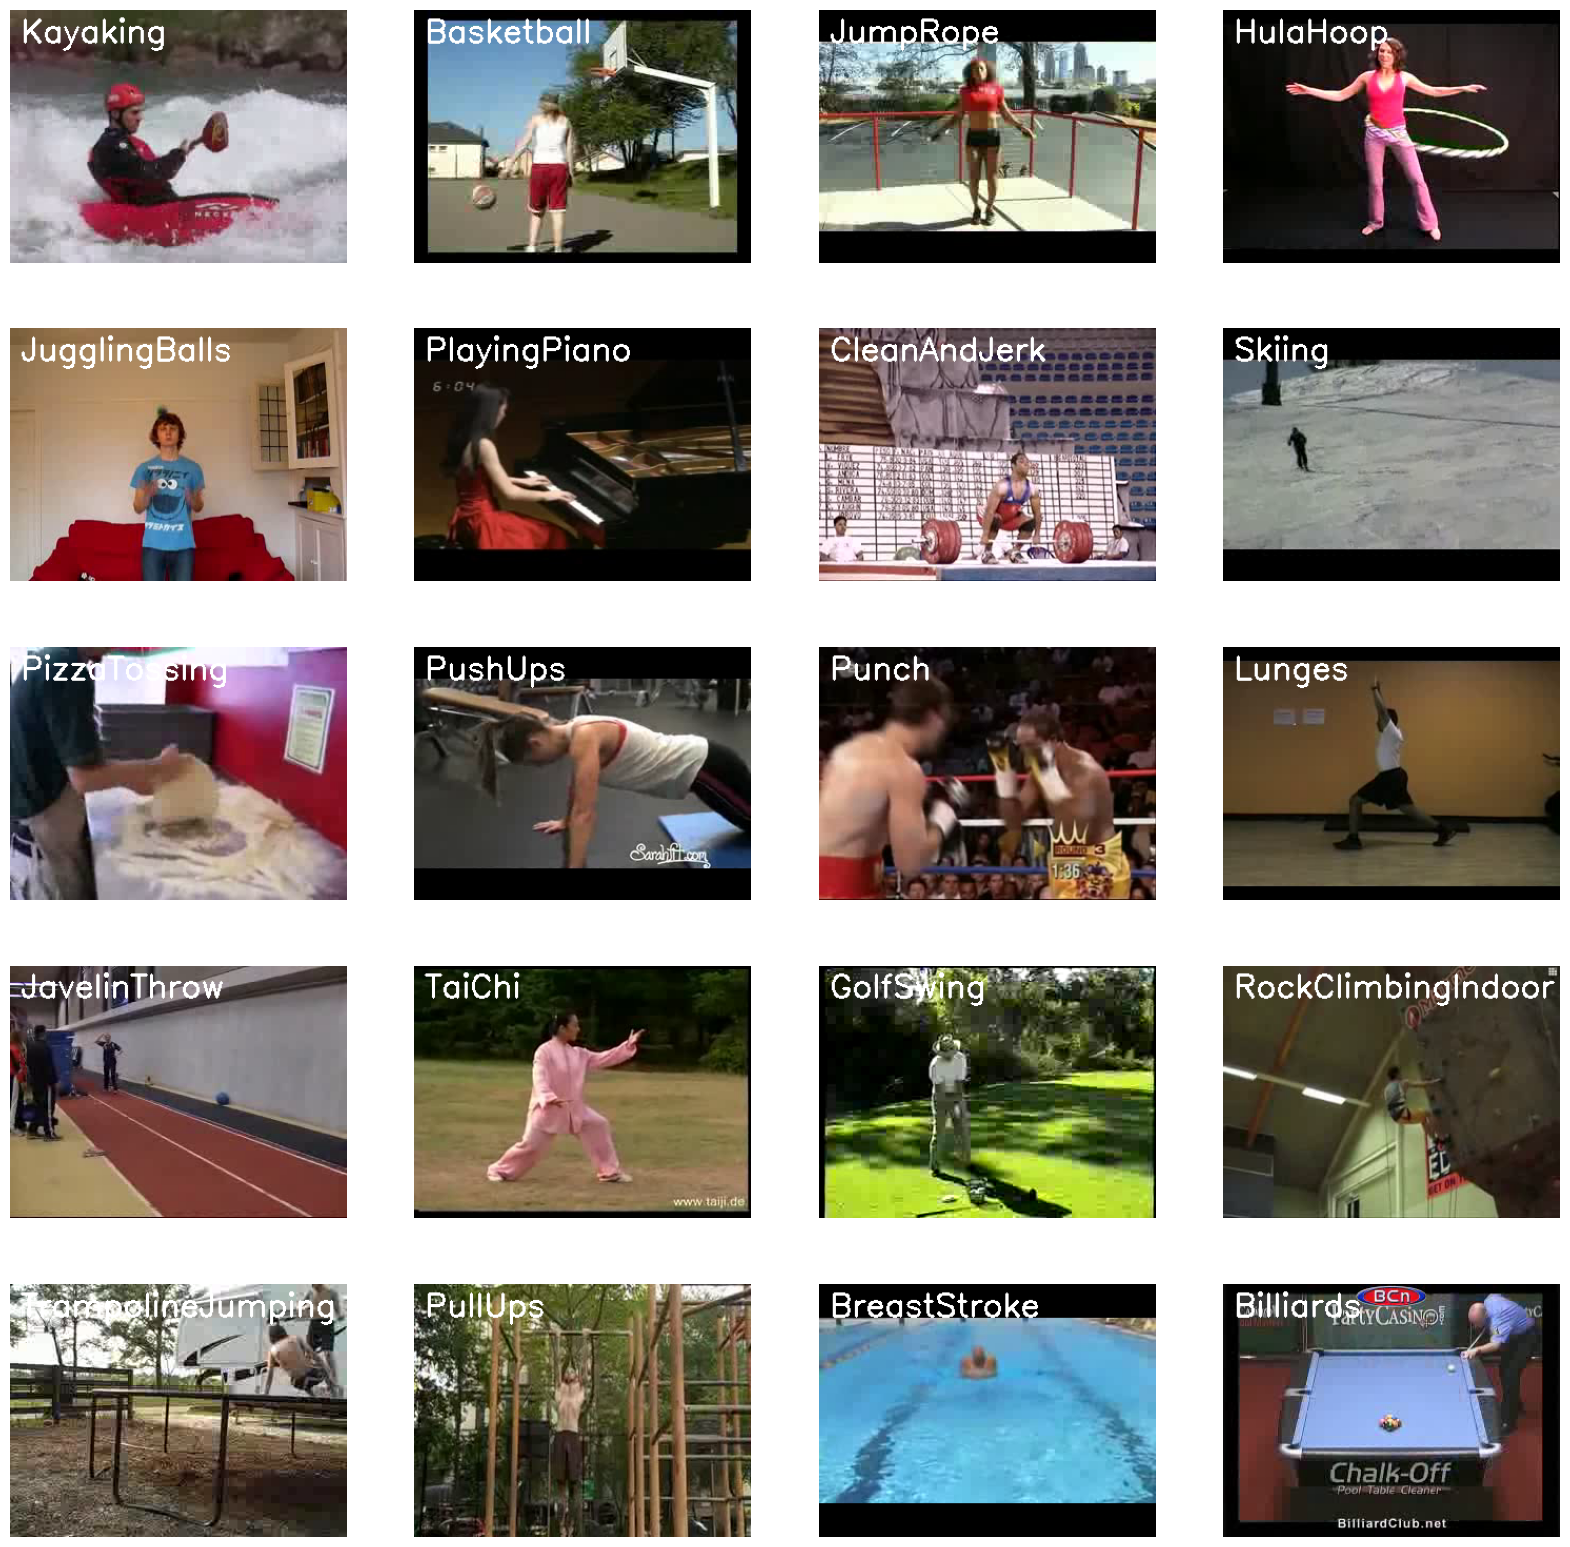

In [4]:
plt.figure(figsize=(20,20))

all_classes_names=os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

#Iterating through all the generated random values.

for counter, random_index in enumerate(random_range, 1):
  selected_class_Name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()
  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  plt.subplot(5, 4, counter); plt.imshow(rgb_frame); plt.axis('off')

# **Preprocess Data**

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH= 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = [
    "WalkingWithDog", "TaiChi", "Swing", "HorseRace",
    "BenchPress", "JumpRope", "PushUps",
    "Basketball", "SkateBoarding", "SoccerJuggling", "TennisSwing"
]

In [6]:
def frames_extraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)  # Fixed here

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255.0

        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [7]:
def create_dataset():
  features = []
  labels= []
  video_files_paths = []
#Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):
      print(f'Extracting Data of Class: {class_name}')
      files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
      for file_name in files_list:
          video_file_path= os.path.join(DATASET_DIR, class_name, file_name)
          frames = frames_extraction(video_file_path)

          if len(frames)== SEQUENCE_LENGTH:
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)

  features= np.asarray(features)
  labels= np.array(labels)
  return features, labels, video_files_paths

In [8]:
 features, labels, video_files_paths= create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: BenchPress
Extracting Data of Class: JumpRope
Extracting Data of Class: PushUps
Extracting Data of Class: Basketball
Extracting Data of Class: SkateBoarding
Extracting Data of Class: SoccerJuggling
Extracting Data of Class: TennisSwing


In [9]:
one_hot_encoded_labels= to_categorical(labels)

# **Split Data Into Train Test**

In [10]:
features_train, features_test, labels_train, labels_test= train_test_split(features, one_hot_encoded_labels,
                                                                           test_size= 0.25,
                                                                           shuffle= True,
                                                                           random_state= seed_constant)

# **Implement the CNN-LSTM Approach**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense

def CNN_LSTM_Model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    # Display the model's summary.
    model.summary()

    # Return the constructed model.
    return model


In [12]:
CNN_LSTM_Model=CNN_LSTM_Model()
print("Model Created Successfully")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │          31,691 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,691 (252.70 KB)

 Trainable params: 64,691 (252.70 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully


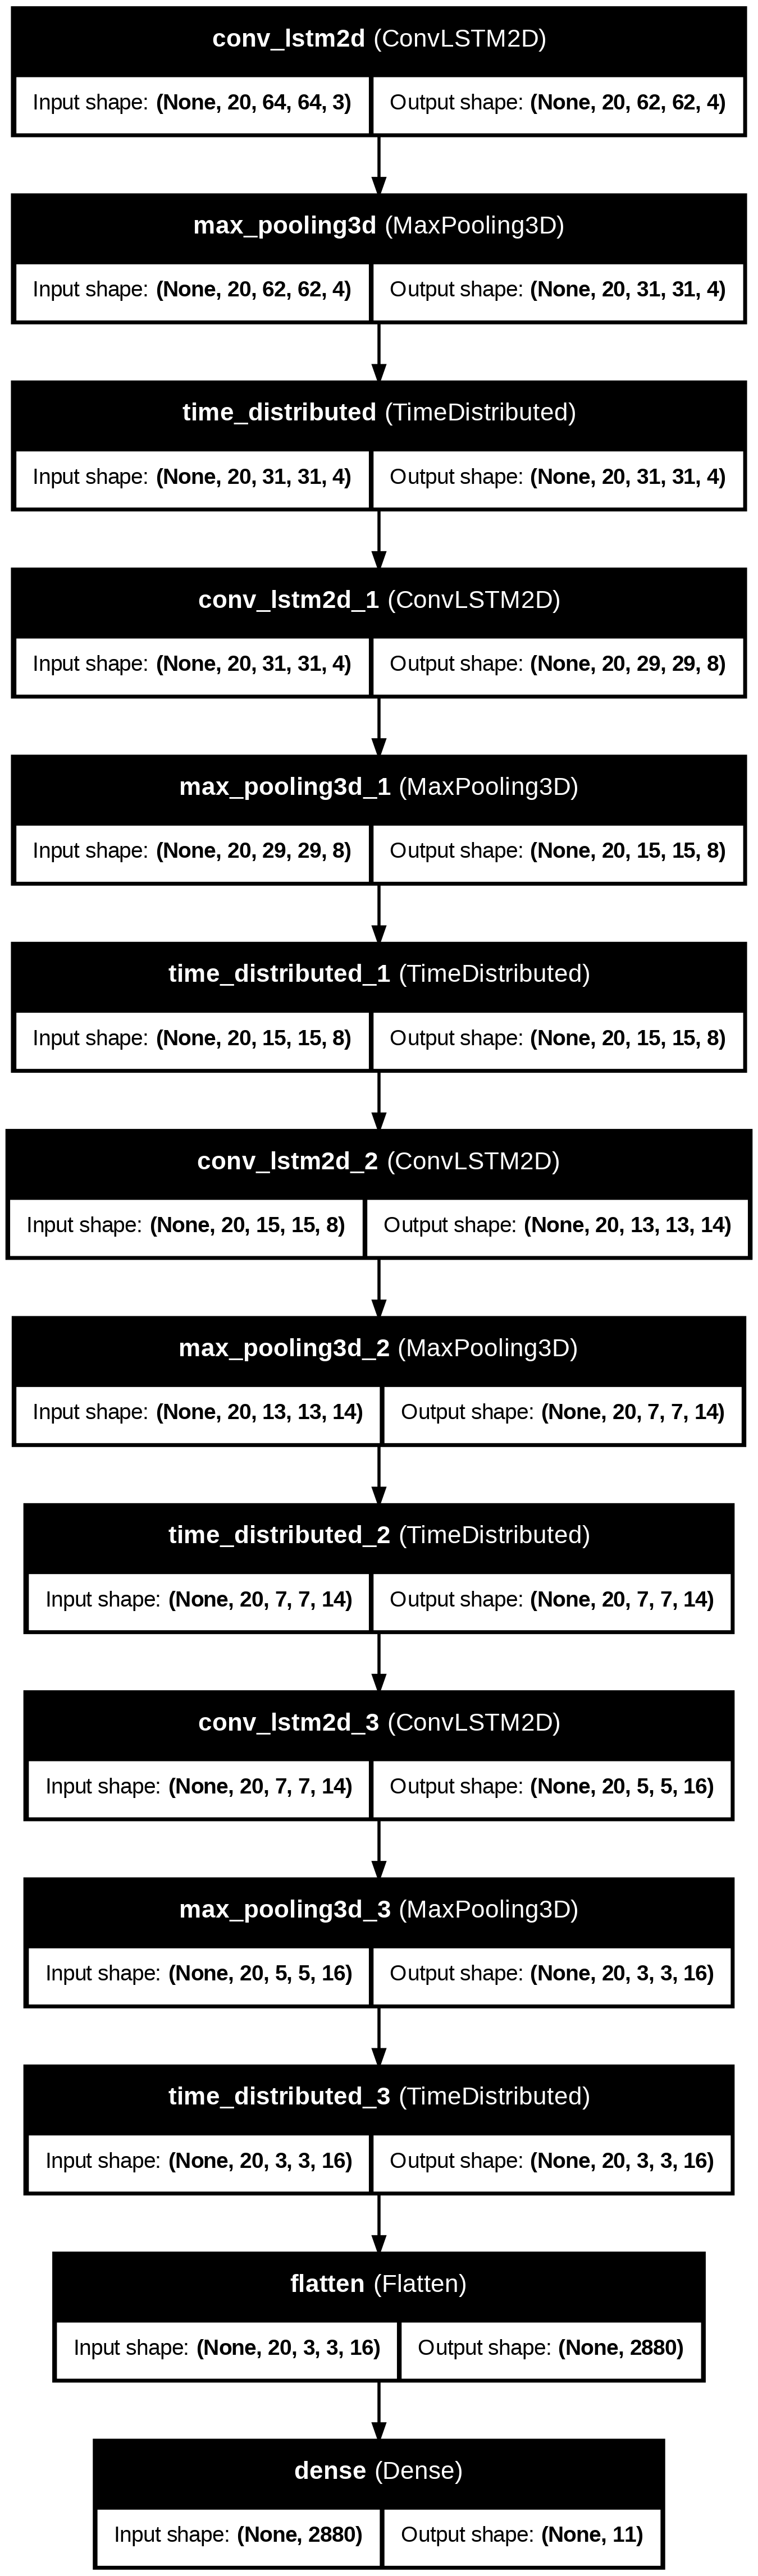

In [13]:
plot_model(CNN_LSTM_Model, to_file="convlstm_model_structure_plot.png", show_shapes=True, show_layer_names=True)

In [14]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=18, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics
CNN_LSTM_Model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model
convlstm_model_training_history = CNN_LSTM_Model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 81ms/step - accuracy: 0.1607 - loss: 2.3314 - val_accuracy: 0.2928 - val_loss: 2.0084
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3603 - loss: 1.7778 - val_accuracy: 0.4505 - val_loss: 1.6614
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.4994 - loss: 1.3978 - val_accuracy: 0.5000 - val_loss: 1.5174
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5585 - loss: 1.1747 - val_accuracy: 0.5766 - val_loss: 1.2955
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6789 - loss: 0.9510 - val_accuracy: 0.5991 - val_loss: 1.2339
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7167 - loss: 0.8113 - val_accuracy: 0.6441 - val_loss: 1.0983
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7854 - loss: 0.6968 - val_accuracy: 0.6577 - val_loss: 1.1910
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7912 - loss: 0.5882 - 

In [16]:
from tensorflow.keras.models import load_model

# Save the model after training
CNN_LSTM_Model.save('CNNLSTM.h5')  # Save the trained model

In [18]:
from tensorflow.keras.models import load_model

CNN_LSTM_Model = load_model('CNNLSTM.h5')  # Load the saved model

In [19]:
model_evaluation_history = CNN_LSTM_Model.evaluate(features_test, labels_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.6970 - loss: 1.0175


In [20]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = "%Y_%m_%d_%H_%M_%S"

current_date_time_dt = dt.datetime.now()

current_date_time_string = current_date_time_dt.strftime(date_time_format)

model_file_name = f'convlstm_model_Date_Time_{current_date_time_string}_Loss_{model_evaluation_loss:.4f}_Accuracy_{model_evaluation_accuracy:.4f}.h5'

CNN_LSTM_Model.save(model_file_name)

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    plt.plot(model_training_history.history[metric_name_1], label=metric_name_1)

    plt.plot(model_training_history.history[metric_name_2], 'red', label=metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

    plt.show()

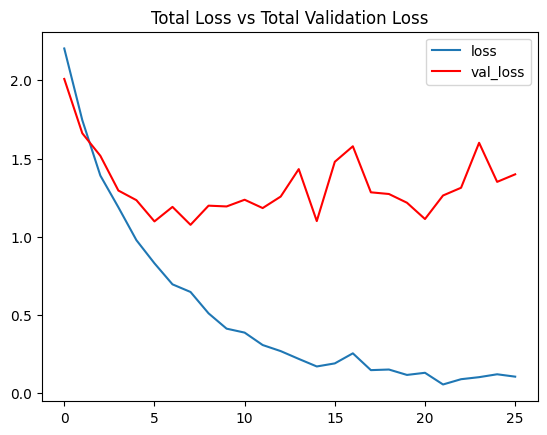

In [22]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

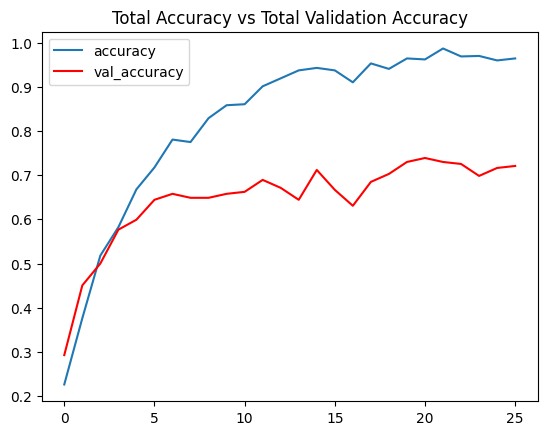

In [23]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [24]:
from sklearn.metrics import classification_report
predictions = CNN_LSTM_Model.predict(features_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step
                precision    recall  f1-score   support

WalkingWithDog       0.30      0.23      0.26        35
        TaiChi       0.48      0.44      0.46        25
         Swing       0.61      0.59      0.60        29
     HorseRace       0.75      0.93      0.83        46
    BenchPress       0.94      1.00      0.97        34
      JumpRope       0.81      0.95      0.88        37
       PushUps       0.83      0.65      0.73        23
    Basketball       0.73      0.73      0.73        30
 SkateBoarding       0.52      0.48      0.50        25
SoccerJuggling       0.67      0.67      0.67        42
   TennisSwing       0.82      0.80      0.81        45

      accuracy                           0.70       371
     macro avg       0.68      0.68      0.68       371
  weighted avg       0.69      0.70      0.69       371



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


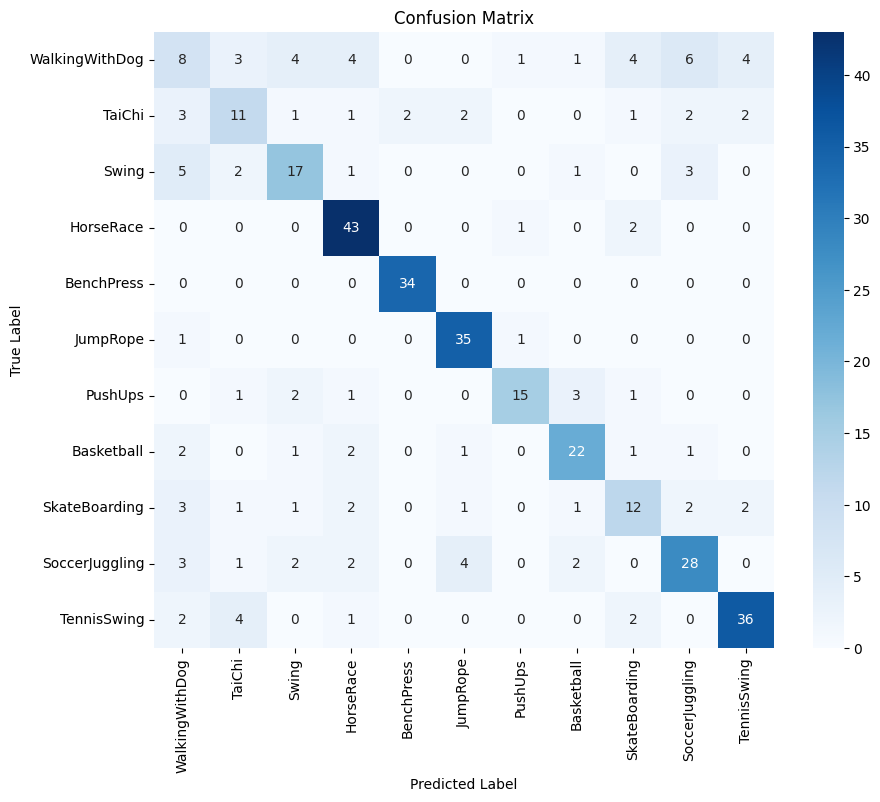

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

predictions = CNN_LSTM_Model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert from one-hot encoding
true_labels = np.argmax(labels_test, axis=1)  # Convert from one-hot encoding

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [26]:
def predict_video(video_path, model):
    frames = frames_extraction(video_path)

    if len(frames) == SEQUENCE_LENGTH:
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension
        prediction = model.predict(frames)
        predicted_label = CLASSES_LIST[np.argmax(prediction)]
        return predicted_label
    return "Error: Not enough frames"

# Test on a random video
sample_video = random.choice(video_files_paths)
predicted_class = predict_video(sample_video, CNN_LSTM_Model)

print(f"Predicted Action: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Action: Swing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


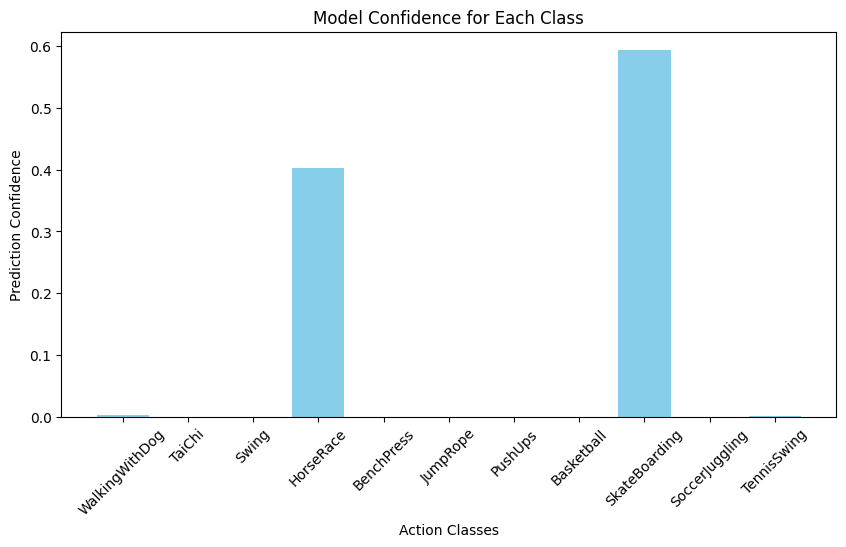

In [28]:
def plot_prediction_distribution(video_path, model):
    frames = frames_extraction(video_path)

    if len(frames) == SEQUENCE_LENGTH:
        frames = np.expand_dims(frames, axis=0)
        predictions = model.predict(frames)[0]

        plt.figure(figsize=(10, 5))
        plt.bar(CLASSES_LIST, predictions, color='skyblue')
        plt.xlabel("Action Classes")
        plt.ylabel("Prediction Confidence")
        plt.title("Model Confidence for Each Class")
        plt.xticks(rotation=45)
        plt.show()

sample_video = random.choice(video_files_paths)
plot_prediction_distribution(sample_video, CNN_LSTM_Model)


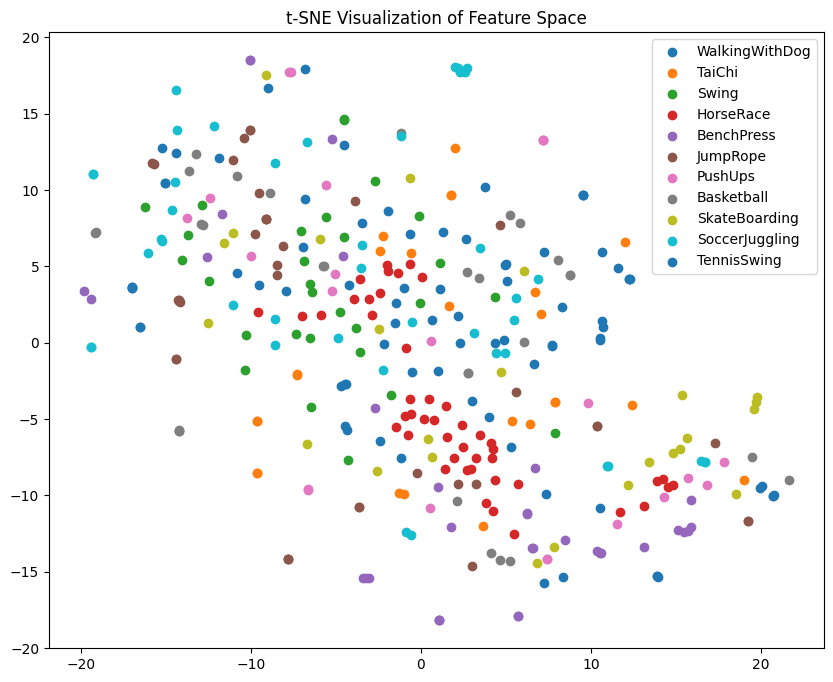

In [30]:
from sklearn.manifold import TSNE

features_flat = features_test.reshape(features_test.shape[0], -1)

tsne = TSNE(n_components=2, random_state=seed_constant)
tsne_features = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(CLASSES_LIST):
    plt.scatter(tsne_features[true_labels == i, 0], tsne_features[true_labels == i, 1], label=class_name)

plt.legend()
plt.title("t-SNE Visualization of Feature Space")
plt.show()
